In [5]:
%pip install numpy matplotlib torch torchvision flopco-pytorch

Note: you may need to restart the kernel to use updated packages.


In [6]:
import time
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

dtype = torch.float32
dtype_bytes = torch.finfo(dtype).bits / 8 # number of bytes per float

Using device cuda


## Arithmetic intensity

In [7]:
# Specs of T4 (colab) for float32, change with your GPU's
peak_flops = 8.1 * 1e12
peak_bandwidth = 300 * 1e9

# pivotal point between compute and memory bound
threshold = peak_flops / peak_bandwidth
print(f"Threshold = {threshold} operations / byte")

def analyze_computation(num_ops, memory_moved):
  # Displays information according to the number of arithmetic operations performed,
  #   and the amount of float transferred

  # Number of operations performed per byte transferred
  arithmetic_intensity = num_ops / memory_moved
  print(f"Arithmetic intensity = {arithmetic_intensity:.4f} operations / byte (threshold = {threshold})")

  # Number of operations per second (bound by our gpu specs)
  print(f"Estimated FLOP/s : {min(peak_flops, arithmetic_intensity * peak_bandwidth) / 1e9:.2f} GFLOP/s")

  if arithmetic_intensity > threshold:
      print("This operation is compute-bound")
  else:
      print("This operation is memory-bound")

Threshold = 27.0 operations / byte


A linear layer is $$y = Wx + b$$

#### How much data is moved?
- $W$ is a matrix of size $n_{out} \times n_{in}$
- $b$ is a vector of size $n_{out}$
- $x$ is a matrix of size $n_{in} \times \text{batch}$
- $y$ is a matrix of size $n_{out} \times \text{batch}$

We need to load $W$, $b$ and $x$, and to store the result $y$:\
$\text{mem} = (n_{out} \times n_{in}) + n_{out} + (n_{in} \times \text{batch}) + (n_{out} \times \text{batch})$

#### How much arithmetic is done?
$\text{num_ops} = \text{batch} \times 2 \times n_{in} \times n_{out}$ \
(see previous lecture)


In [8]:
batch_size = 1
nin = 1024
nout = 1024

x = torch.randn(batch_size, nin, device=device, dtype=dtype)
layer = torch.nn.Linear(nin, nout, bias=True, device = device)

# Apply formulas above
num_ops = batch_size * (2 * nout * nin)
memory_moved = (nout * nin) + nout + (nin * batch_size) + (nout * batch_size)
memory_moved *= dtype_bytes # never forget to multiply by dtype

analyze_computation(num_ops, memory_moved)

# See if we can measure the same flops as expected
niters = 1000
y = layer(x) # warmup & pre-allocation
start = time.time()
for _ in range(niters):
    y = layer(x)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    end = time.time()
elapsed = time.time() - start

print(f"Time taken: {elapsed}s")
achieved_flops = (num_ops * niters) / elapsed
print(f"Achieved FLOP/s: {achieved_flops / 1e9:.2f} GFLOP/s ({100 * achieved_flops / peak_flops:.2f}% of theoretical max)")

from torch.utils.flop_counter import FlopCounterMode

with FlopCounterMode() as fc:
    y = layer(x)

print(f"Estimated by us: {num_ops} ; estimated by torch: {fc.get_total_flops()}")

Arithmetic intensity = 0.4985 operations / byte (threshold = 27.0)
Estimated FLOP/s : 149.56 GFLOP/s
This operation is memory-bound
Time taken: 0.05434441566467285s
Achieved FLOP/s: 38.59 GFLOP/s (0.48% of theoretical max)
Module              FLOP    % Total
-------------  ---------  ---------
Linear         2097.152K    100.00%
 - aten.addmm  2097.152K    100.00%
Estimated by us: 2097152 ; estimated by torch: 2097152


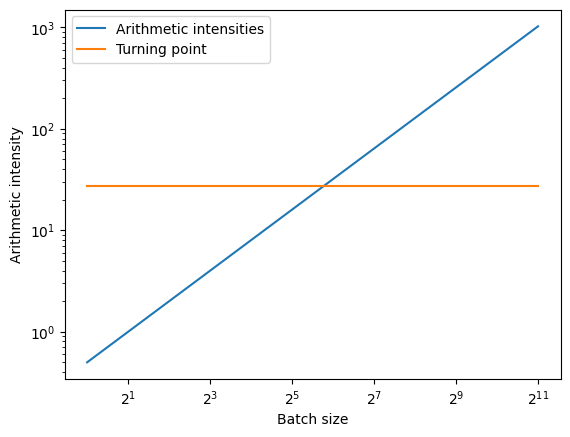

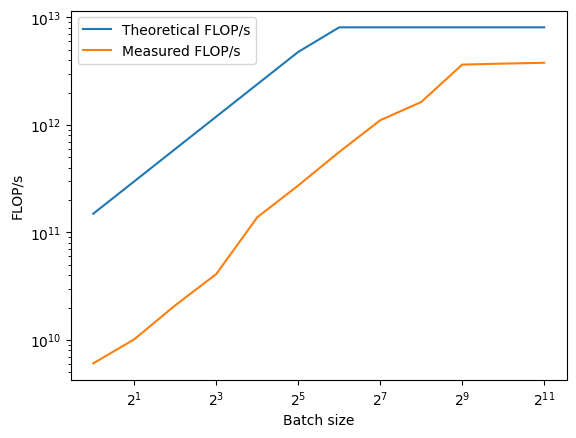

In [9]:
import matplotlib.pyplot as plt

sizes = [2 ** x for x in range(12)]
theoretical_flops = []
measured_flops = []
arithmetic_intensities = []
for b in sizes:
  # We can estimate with formulas
  num_ops = b * (2 * nout * nin)
  memory_moved = (nout * nin) + nout + (nin * batch_size) + (nout * batch_size)
  memory_moved *= dtype_bytes
  ai = num_ops / memory_moved
  arithmetic_intensities.append(ai)
  estimated_flops = min(peak_flops, ai * peak_bandwidth)
  theoretical_flops.append(estimated_flops)

  # Or use FlopCounterMode to get theoretical flops
  # And measure time
  x = torch.randn(b, nin, device=device, dtype=dtype)
  y = layer(x) # warmup & pre-allocation
  with FlopCounterMode(display=False) as fc:
    start = time.time()
    y = layer(x)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    end = time.time()
  measured_flops.append(fc.get_total_flops() / (end - start))

plt.plot(sizes, arithmetic_intensities, label = "Arithmetic intensities")
plt.plot(sizes, [threshold for _ in sizes], label = "Turning point")
plt.yscale("log")
plt.xscale("log", base = 2)
plt.xlabel("Batch size")
plt.ylabel("Arithmetic intensity")
plt.legend()
plt.show()

plt.plot(sizes, theoretical_flops, label = "Theoretical FLOP/s")
plt.plot(sizes, measured_flops, label = "Measured FLOP/s")
plt.xlabel("Batch size")
plt.ylabel("FLOP/s")
plt.yscale("log")
plt.xscale("log", base=2)
plt.legend()
plt.show()


Another simple example is an element-wise operation such as ReLU.

Number of operations = number of elements \
Number of bytes moved = number of elements * 2 (load and store)

In [10]:
num_ops = b * nin
memory_moved = 2 * nin * nout * b
memory_moved *= dtype_bytes

analyze_computation(num_ops, memory_moved)

x = torch.randn(b, nin, device=device, dtype=dtype)
y = torch.empty_like(x)

niters = 1000
y = x.relu() # warmup & pre-allocation
start = time.time()
for _ in range(niters):
    y = x.relu()
if torch.cuda.is_available(): torch.cuda.synchronize()
end = time.time()
elapsed = (end - start)

print(f"Time taken: {elapsed}s")
achieved_flops = (num_ops * niters) / elapsed
print(f"Achieved FLOP/s: {achieved_flops / 1e9:.2f} GFLOP/s ({100 * achieved_flops / peak_flops:.2f}% of theoretical max)")


Arithmetic intensity = 0.0001 operations / byte (threshold = 27.0)
Estimated FLOP/s : 0.04 GFLOP/s
This operation is memory-bound
Time taken: 0.052577972412109375s
Achieved FLOP/s: 39.89 GFLOP/s (0.49% of theoretical max)


Can you find a case where ReLU is compute bound? What would it need in order to be possible?

Element-wise operations such as ReLU are heavily memory bound. One way to improve their efficiency is to do *operation fusing* to limit memory transfers.


```
                    |--->|                              |--->|
                    |    |                              |    |
                    |<---|                              |    |
               data |    | compute                 data |    | compute
                    |--->|                              |    |
                    |    |                              |    |
                    |<---|                              |<---|

```



In [11]:
b = 64
c_in = 1
c_out = 256
h = 30
w = 30
k = 3

model = nn.Sequential(
    nn.Conv2d(c_in, c_out, k, padding = 'same', bias = False),
    nn.BatchNorm2d(c_out),
    nn.ReLU()
).to(device)
model.eval()

h_out, w_out = h, w # we used padding "same"

num_ops = b * c_in * c_out * h * w * (k**2) # conv
num_ops += 2 * b * c_out * h_out * w # batch norm
num_ops += b * c_out * h_out * w_out # relu
memory_moved = c_in * c_out * (k**2) # conv parameters
memory_moved += b * c_in * h_out * w_out # img
memory_moved += b * c_out * h_out * w_out # store output of conv
memory_moved += b * c_out * h_out * w_out # re-load it for batchnorm
memory_moved += b * c_out * h_out * w_out # store it after batchnorm
memory_moved += b * c_out * h_out * w_out # re-load it for relu
memory_moved += b * c_out * h_out * w_out # store it after relu
memory_moved *= dtype_bytes


print("\n-- Without fusion --\n")
analyze_computation(num_ops, memory_moved)

x = torch.randn(b, c_in, h, w, device=device, dtype=dtype)

niters = 100
y = model(x) # warmup & pre-allocation
start = time.time()
for _ in range(niters):
    y = model(x)
if torch.cuda.is_available(): torch.cuda.synchronize()
end = time.time()
elapsed = end - start

achieved_flops = (num_ops * niters) / elapsed
print(f"Time taken: {elapsed}s")
print(f"Achieved FLOP/s: {achieved_flops / 1e9:.2f} GFLOP/s ({100 * achieved_flops / peak_flops:.2f}% of theoretical max)")


print("\n-- With fusion --\n")
# Inference only!
fused_model = torch.ao.quantization.fuse_modules(model, ['0', '1', '2']) # fuse modules 0, 1 and 2

memory_moved -= 4 * b * (c_out * h_out * w_out) # we got rid of two back-and-forth
analyze_computation(num_ops, memory_moved)

y = fused_model(x) # warmup & pre-allocation
start = time.time()
for _ in range(niters):
    y = fused_model(x)
if torch.cuda.is_available(): torch.cuda.synchronize()
end = time.time()

elapsed = end - start
achieved_flops = (num_ops * niters) / elapsed
print(f"Time taken: {elapsed}s")
print(f"Achieved FLOP/s: {achieved_flops / 1e9:.2f} GFLOP/s ({100 * achieved_flops / peak_flops:.2f}% of theoretical max)")


-- Without fusion --

Arithmetic intensity = 0.5995 operations / byte (threshold = 27.0)
Estimated FLOP/s : 179.85 GFLOP/s
This operation is memory-bound
Time taken: 0.11283326148986816s
Achieved FLOP/s: 156.82 GFLOP/s (1.94% of theoretical max)

-- With fusion --

Arithmetic intensity = 0.7492 operations / byte (threshold = 27.0)
Estimated FLOP/s : 224.77 GFLOP/s
This operation is memory-bound
Time taken: 0.11231255531311035s
Achieved FLOP/s: 157.55 GFLOP/s (1.95% of theoretical max)


**Exercise:** In this example, both non-fused and fused models are memory bound. Can you create a model that is originally memory-bound, and becomes compute-bound when fusing it ?

**Exercise:** Finding the amount of memory transfers needed for a big model is tedious. Write a piece of code that extracts this data from an execution. Then, use FlopCo or torch's flop counter to find the arithmetic intensity of each layer.

*Hint: FlopCo gives info about input/output shapes for each layer*

In [12]:
from torchvision.models import resnet18
model = resnet18()

from flopco import FlopCo

stats = FlopCo(model, img_size = (1, 3, 224, 224), instances = [nn.Conv2d, nn.Linear, nn.BatchNorm2d])

print(f"Available data: {dir(stats)}")

for lname in stats.flops.keys():
  # TODO: Automatically compute the memory transferred
  #         and the arithmetic intensity of each layer
  ...



Available data: ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_save_flops', '_save_macs', '_save_shapes', 'count_params', 'custom_tensor', 'device', 'flops', 'get_ltypes', 'get_stats', 'img_size', 'input_shapes', 'instances', 'ltypes', 'macs', 'output_shapes', 'params', 'relative_flops', 'relative_macs', 'relative_params', 'total_flops', 'total_macs', 'total_params']


## Memory estimation

In [13]:
!nvidia-smi

Wed Dec 11 17:50:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   60C    P2             44W /  170W |    1538MiB /  12288MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
total_mem = torch.cuda.get_device_properties(device).total_memory
print(f"Total memory : {total_mem / 2**30:.3f} GB")

Total memory : 11.755 GB


Let's consider the model below:

In [15]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(512, 256, bias = False),
    nn.LayerNorm(256),
    nn.ReLU(),
    nn.Linear(256, 10, bias = False)
)

nparams = sum(p.numel() for p in model.parameters())
print(f"Number of parameters : {nparams}")
# Some layers like BatchNorm also use buffers during training
print(f"Number of buffers : {sum(p.numel() for p in model.buffers())}")

batch_size = 32
criterion = nn.CrossEntropyLoss()

Number of parameters : 134144
Number of buffers : 0


We can estimate the memory needed to train this model:

- Parameters: $\text{nb_params}$
- Activations:
    - Linear 1 : $B \times 256$
    - LayerNorm: $B \times 256$
    - ReLU: $B \times 256$
    - Linear 2: $B \times 10$
- Gradients: $\text{nb_params}$
- Optimizer states: $2 \times \text{nb_params}$ (for Adam)

Everything is float32, so we multiply by 4.

In [16]:
params_mem = nparams * dtype_bytes
activations_mem = batch_size * (3 * 256 + 10) * dtype_bytes
grads_mem = nparams * dtype_bytes
optimizer_mem = 2 * nparams * dtype_bytes

# Reset
model.cpu()
model.zero_grad()

x = torch.randn(batch_size, 512)
target = torch.randint(0, 10, (batch_size,))

if torch.cuda.is_available():
    initial_mem = torch.cuda.memory_allocated()

    model.cuda()
    print(f"Estimated: {params_mem}, actual : {torch.cuda.memory_allocated() - initial_mem}")

    output = model(x.cuda())
    print(f"Estimated: {params_mem + activations_mem}, actual : {torch.cuda.memory_allocated() - initial_mem}")

    loss = criterion(output, target.cuda())
    loss.backward()
    print(f"Estimated: {params_mem + grads_mem}, actual : {torch.cuda.memory_allocated() - initial_mem}") # Activations were freed after backward

    optimizer = torch.optim.Adam(model.parameters())
    optimizer.step()
    print(f"Estimated: {params_mem + grads_mem + optimizer_mem}, actual : {torch.cuda.memory_allocated() - initial_mem}")



Estimated: 536576.0, actual : 536576
Estimated: 636160.0, actual : 670208
Estimated: 1073152.0, actual : 9594880
Estimated: 2146304.0, actual : 10668032


### PyTorch profiler

Torch provides an useful tool to analyze both memory and cuda/cpu computation. Here's an example on how to run it.

In [17]:
from torch.profiler import profile, record_function, ProfilerActivity
# Profile one training step
if torch.cuda.is_available():
  activity = ProfilerActivity.CUDA
  dev_name = 'cuda'
else:
  activity = ProfilerActivity.CPU
  dev_name = 'cpu'

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters())
with profile(activities=[activity],
            profile_memory=True, with_flops=True) as prof:
    with record_function("training_batch"):
        # Forward pass
        output = model(x.to(device))
        loss = criterion(output, target.to(device))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Print profiling results
print(prof.key_averages().table(sort_by=f"self_{dev_name}_time_total", row_limit=10))

print(prof.key_averages().table(sort_by=f"self_{dev_name}_memory_usage", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
void at::native::(anonymous namespace)::multi_tensor...         0.00%       0.000us         0.00%       0.000us       0.000us      13.088us        19.60%      13.088us      13.088us           0 b           0 b             1  
                        ampere_sgemm_64x32_sliced1x4_tn         0.00%       0.000us         0.0

[W1211 17:50:21.059217253 collection.cpp:979] Warning: Failed to recover relationship between all profiler and kineto events: 42 vs. 0  reassociated. (function reassociate)


**Exercise:** Take a more complex model (from torchvision, huggingface, or one that you used before) and try to profile it. Does it fit in memory? What's taking most of the time? And memory?  

In [18]:
if torch.cuda.is_available():
    torch.cuda.memory._record_memory_history()
    # Move model and data to GPU
    model = model.cuda()
    x = x.cuda()
    target = target.cuda()

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Do a few training steps to warm up
    for _ in range(3):
        output = model(x)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Export memory snapshot
    print("\nGPU Memory Usage:")
    print("-" * 40)
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.1f} MB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.1f} MB")
    print("\nDetailed memory summary:")
    print(torch.cuda.memory_summary())
    torch.cuda.memory._dump_snapshot("my_snapshot.pickle")


GPU Memory Usage:
----------------------------------------
Allocated: 78.8 MB
Cached: 102.0 MB

Detailed memory summary:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  80737 KiB | 308850 KiB |  38731 MiB |  38652 MiB |
|       from large pool |  78336 KiB | 308608 KiB |  36496 MiB |  36420 MiB |
|       from small pool |   2401 KiB |   5104 KiB |   2235 MiB |   2232 MiB |
|---------------------------------------------------------------------------|
| Active memory     

[W1211 17:50:21.085914597 unwind.cpp:214] Warning: Unsupported unwinding pattern: Address not in range (function unwinderFor)


Go to https://pytorch.org/memory_viz and upload the snapshot for a visualisation.

## Graph tracing & compiling

When using complex models, it can be useful to extract the structure of the computation to know what's happening, and where are the bottlenecks.

Torch provides different ways to extract a *computation graph* from a model. Here's how to use ``torch.fx``.

In [19]:
import torch.fx as fx
model = resnet18()

trace = fx.symbolic_trace(model)

# Static Single-Assignment code
print(trace.code)




def forward(self, x : torch.Tensor) -> torch.Tensor:
    conv1 = self.conv1(x);  x = None
    bn1 = self.bn1(conv1);  conv1 = None
    relu = self.relu(bn1);  bn1 = None
    maxpool = self.maxpool(relu);  relu = None
    layer1_0_conv1 = getattr(self.layer1, "0").conv1(maxpool)
    layer1_0_bn1 = getattr(self.layer1, "0").bn1(layer1_0_conv1);  layer1_0_conv1 = None
    layer1_0_relu = getattr(self.layer1, "0").relu(layer1_0_bn1);  layer1_0_bn1 = None
    layer1_0_conv2 = getattr(self.layer1, "0").conv2(layer1_0_relu);  layer1_0_relu = None
    layer1_0_bn2 = getattr(self.layer1, "0").bn2(layer1_0_conv2);  layer1_0_conv2 = None
    add = layer1_0_bn2 + maxpool;  layer1_0_bn2 = maxpool = None
    layer1_0_relu_1 = getattr(self.layer1, "0").relu(add);  add = None
    layer1_1_conv1 = getattr(self.layer1, "1").conv1(layer1_0_relu_1)
    layer1_1_bn1 = getattr(self.layer1, "1").bn1(layer1_1_conv1);  layer1_1_conv1 = None
    layer1_1_relu = getattr(self.layer1, "1").relu(layer1_1_bn1);  

In [20]:
from torch.fx.passes.graph_drawer import FxGraphDrawer

drawer = FxGraphDrawer(trace, 'computation graph')
drawer.get_dot_graph().write_svg('./graph.svg')

RuntimeError: FXGraphDrawer requires the pydot package to be installed. Please install pydot through your favorite Python package manager.

In [ ]:

# New feature added in torch 2.0: lots of stuff happening there!
compiled = torch.compile(model)

# Let's compare performance with the original model
x = torch.randn(16, 3, 224, 224)
niters = 5

y = model(x) # warmup
start = time.time()
for _ in range(niters):
  y = model(x)
if torch.cuda.is_available(): torch.cuda.synchronize()
end = time.time()
print(f"Time taken by original model : {end - start:.3f}s")


y = compiled(x) # warmup
start = time.time()
for _ in range(niters):
  y = compiled(x)
if torch.cuda.is_available(): torch.cuda.synchronize()
end = time.time()
print(f"Time taken by compiled model : {end - start:.3f}s")